In [1]:
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
from matplotlib import mlab
%matplotlib widget

from tqdm.notebook import tqdm


from statsmodels.regression.linear_model import yule_walker
from scipy.ndimage import uniform_filter1d
from eofs.standard import Eof
from statsmodels.tsa.stattools import pacf
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator

import xarray as xr

import sys
sys.path.append('../')
from general_purpose import cartopy_plots as cplt

# Data resampling
The detrended temperature anomaly data is imported and resampled on the grid used in the VEROS simulation

In [ ]:
noise_product_name='atlantic'

In [3]:
lm = xr.open_dataarray('landmask_veros4x4.nc')
vlon = lm.lon.data
vlat = lm.lat.data
lm

<xarray.DataArray (lat: 40, lon: 90)>
[3600 values with dtype=bool]
Coordinates:
  * lon      (lon) float64 -272.0 -268.0 -264.0 -260.0 ... 72.0 76.0 80.0 84.0
  * lat      (lat) float64 -82.38 -77.62 -72.89 -68.19 ... 63.38 68.11 72.87

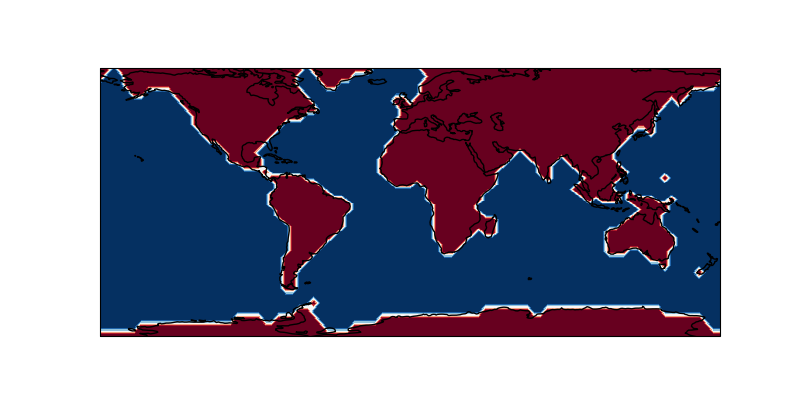

In [4]:
plt.close(1)
fig = plt.figure(num=1, figsize=(8,4))
ax = fig.add_subplot(111, projection=cplt.ccrs.PlateCarree())

cplt.geo_plotter(ax, *np.meshgrid(vlon,vlat),
                 lm.data,
                 greenwich=True,
                 draw_gridlines=False, draw_labels=False,
                 put_colorbar=False
                )

In [5]:
detrend_data = np.load('HEAVY--detrended_dataframe_tr.npy',allow_pickle=True) # Detrended data
print(f'{detrend_data.shape = }')

# The land mask for VEROS is imported and land values (1) are replaced by np.nan and saved in 'landMask.npy'
landMask_0 = np.flipud(lm.data)
landMask = np.where(landMask_0 == 1, np.nan, 1)

s_data = np.shape(detrend_data)
t = np.linspace(0,s_data[0]-1,s_data[0])
lat = np.arange(0,180)
long = np.arange(0,360) 
f = RegularGridInterpolator((t,lat, long), detrend_data)
x_long = vlon + 272
y_lat = 90 - np.flip(vlat)

tt,yt,xt = np.meshgrid(t,y_lat, x_long,indexing = 'ij') 
test_points = np.array([tt.ravel(),yt.ravel(),xt.ravel()]).T

rescaledGrids = f(test_points).reshape(s_data[0], 40,90)
np.save('HEAVY--rescaledGrids.npy', rescaledGrids)
#rescaledGrids  = np.load('rescaledGrids.npy')

print(f'{rescaledGrids.shape = }')

detrend_data.shape = (1711, 180, 360)
rescaledGrids.shape = (1711, 40, 90)


## Plot the land mask

In [6]:
fvlat = np.flip(vlat)
LON, LAT = np.meshgrid(vlon, fvlat)

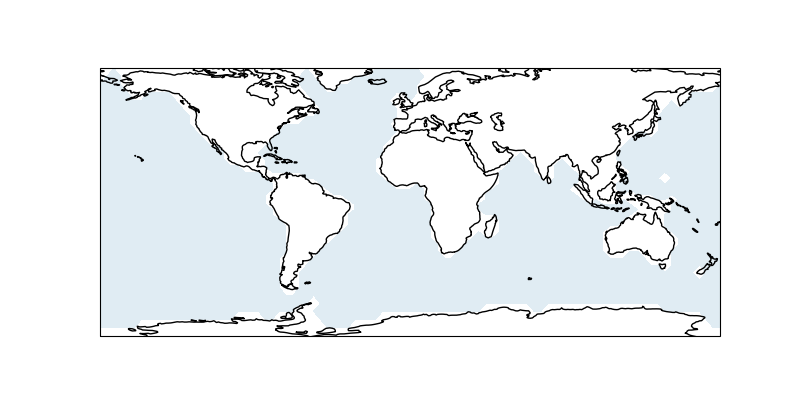

In [7]:
plt.close(1)
fig = plt.figure(num=1, figsize=(8,4))
ax = fig.add_subplot(111, projection=cplt.ccrs.PlateCarree())

cplt.geo_plotter(ax, LON, LAT,
                 landMask,
                 greenwich=True,
                 draw_gridlines=False, draw_labels=False,
                 put_colorbar=False
                )

### Mask only the Atlantic

In [ ]:
atlantic_mask = np.copy(landMask)

# mask out everything below 35 deg south
atlantic_mask[fvlat < -35, :] = np.nan

atlantic_mask[:, vlon > 25] = np.nan
atlantic_mask[:, vlon < -120] = np.nan

for i in range(atlantic_mask.shape[0]):
    if fvlat[i] > 20 or fvlat[i] < -35:
        continue
    j = np.nanargmax(atlantic_mask[i])
    while not np.isnan(atlantic_mask[i,j]):
        j += 1
    atlantic_mask[i,:j] = np.nan
    
atlantic_mask[:, vlon < -100] = np.nan

plt.close(2)
fig = plt.figure(num=2, figsize=(4,4))
ax = fig.add_subplot(111, projection=cplt.ccrs.PlateCarree())

cplt.geo_plotter(ax, LON, LAT,
                 atlantic_mask,
                 greenwich=True,
                 draw_gridlines=False, draw_labels=False,
                 put_colorbar=False
                )

In [ ]:
landMask = atlantic_mask

# EOFs and PCs
Now that the data has been resampled, we can do the EOF analysis. Here we use the EOFs expressed as covariance and use the narmlized PCs.


In [ ]:
solver_re = Eof(rescaledGrids*landMask) # The EOFs are calculated after applying the landmask, since we are only interested in the ocean dynamics
eof_re = solver_re.eofsAsCovariance()
pc_re = solver_re.pcs(pcscaling = 1)

As a sanity check we recontruct a grid from the data using the EOFs and PCs and plot the residual.

In [ ]:
month_id = 1000
grid0 = np.tensordot(pc_re[month_id],eof_re*landMask, axes = ([0],[0])) #linear combination of EOFs using PC coefficients
plt.figure()
plt.imshow(grid0)# PCs and EOFs reproced grid
plt.colorbar()
plt.figure()
plt.imshow(rescaledGrids[month_id]*landMask) # True data grid
plt.colorbar()
plt.figure()
plt.imshow(rescaledGrids[month_id]*landMask-grid0)#Difference
plt.colorbar()

We can estimate the fraction of the variance explained by the number of EOFs used and determine how many EOFs to use in the AR-model, based on some cut-off. A larger cut off leads to more EOFs which is more computationally intesive.

In [ ]:
varfrac = 0.9


var_pc_re = solver_re.varianceFraction()
var_pc_re_sum = np.cumsum(var_pc_re)

plt.figure()
plt.plot(var_pc_re_sum)
plt.xlabel('Nr. of EOFs')
plt.ylabel('Variace Fraction')
plt.grid(alpha = 0.95)
plt.axhline(varfrac, label=f'{varfrac*100}%', color='red')
plt.legend()

def pick_pc_re(exp_var):
    print(np.argmin(np.abs(var_pc_re_sum-exp_var)))
    return np.argmin(np.abs(var_pc_re_sum-exp_var))

nr_eofs = int(pick_pc_re(varfrac)) # Print the number of EOFs needed to have a var. frac. of 90%

## Visualize the EOFs

In [ ]:
# vmax = np.nanmax(np.abs(eof_re))
ofl = (3,8)
start = 12

plt.close('all')
plots_per_fig = np.prod(ofl)
i = 0
while True:
    lower = start + plots_per_fig*i
    upper = min(start + plots_per_fig*(i+1), nr_eofs)
    if upper <= lower:
        break
    ims = cplt.mfp(LON, LAT, (eof_re[lower:upper]*landMask).transpose(1,2,0),
                   projections=cplt.ccrs.PlateCarree(), extents=(-120, 40, -40, 90), titles=list(range(lower + 1,upper + 1)),
                   figsize=(16,7),
                   # figsize=(12,6),
                   # figsize=(18,6),
                   fig_num = 8 + i,
                   one_fig_layout=ofl,
                   # mx=vmax,
                   # colorbar='shared',
                   colorbar='individual',
                   put_colorbar=False,
                   # apply_tight_layout=False
                  )
    i += 1

In [ ]:
plt.close('all')

In [ ]:
e = 0

cplt.mfp(LON, LAT, eof_re[e:e+1].transpose(1,2,0),
                   projections=cplt.ccrs.PlateCarree(), extents=None, titles=None,
                   # figsize=(18,9),
                   figsize=(12,6),
                   fig_num = 2,
                   one_fig_layout=False,
                   # mx=vmax,
                   # colorbar='shared',
                   colorbar='individual',
                   # put_colorbar=False,
                   # apply_tight_layout=False
                  )

Now we can determine the lag of each AR model for each PC. This is done by computing the Partial Autocorrelation Function for each index in the PCs.
We set a significance level as $\alpha = 0.0001$.

In [ ]:
lags = 200
pacf_lag_re = np.zeros(nr_eofs)
acf_lag_re = np.zeros(nr_eofs)
thresholdList_re = np.zeros([nr_eofs, lags+1])
confList_re = np.zeros(nr_eofs)
for i in tqdm(range(nr_eofs)):
    p_re, conf_re = pacf(pc_re[:,i],alpha = 0.0001, nlags = lags, method = 'ywm') # the pacf is computed for each time series
    conf_set_re = np.asarray([conf_re[j,1]-p_re[j] for j in range(lags+1)]) #The confidence interval is set
    pacf_lag_re[i] = np.amax(np.nonzero(np.where(np.abs(p_re)>conf_set_re,1,0))) # masking the pacf with 1 or 0 when inside or outside of confidence interval
    thresholdList_re[i,:] = np.abs(p_re) 
    confList_re[i] = conf_set_re[1]
    
print(pacf_lag_re)

In [ ]:
#plot the lag estimated for each PC
plt.figure()
plt.plot(pacf_lag_re, '-o',label = 'pacf')
plt.xlabel('PC')
plt.ylabel('Max Lag (re)')
plt.legend()

In [ ]:
plt.close(5)
fig,ax = plt.subplots(figsize=(9,6), num=5)

plt.plot(pc_re[:,2])

fig.tight_layout()

# Yule-Walker
We use the Yule-Walker method to estimate the AR-model for each PC given the lag

In [ ]:
l_m = int(np.amax(pacf_lag_re)) # Find the maximal lag used and make an [maxLag x Nr_eofs] array - this seems faster than treating Nr_eofs arrays individually
rho, sig= np.zeros([nr_eofs,l_m]), np.zeros(nr_eofs)  
for i in range(nr_eofs): # for each eof/PC-index we fit an AR(n)-model to the time series
    rho[i,:int(pacf_lag_re[i])], sig[i] = yule_walker(pc_re[:,i],order = int(pacf_lag_re[i]))

## Save the noise product

In [ ]:
# create directory
os.makedirs(noise_product_name, exist_ok=True)

# land mask
np.save(f'{noise_product_name}/landMask.npy',landMask) 

# number of autoregreesive terms for each eof
np.save(f'{noise_product_name}/Lags.npy', pacf_lag_re)

#EOFs and their time-series
np.save(f'{noise_product_name}/EOFs.npy',eof_re[:nr_eofs])
np.save(f'{noise_product_name}/PCs.npy',pc_re[:,:nr_eofs])

#coefficients and sigma for the white noise
np.save(f'{noise_product_name}/yw_rho.npy', rho)
np.save(f'{noise_product_name}/yw_sigma.npy', sig)

logging.log(45, f"\n\nNow save and clear all output of this notebook and save a copy inside '{noise_product_name}'")

# Running Noise Model
We set up the noise field generator with an initialization and a step function.
This is essentially the same noise as on the cluster in the setup_5y_new directory 

In [ ]:
def initialize():
    pc_lag_re = np.zeros([nr_eofs,l_m])
    pc_lag_re[:,0] = np.zeros_like(nr_eofs)
    pc_series_re = np.zeros(nr_eofs)

    grid = np.zeros([2,40,90])
    for p in range(nr_eofs):
        lag = int(pacf_lag_re[p])
        pc_lag_re[p,l_m-1] = np.dot(pc_lag_re[p,:lag],rho[p,:lag])+np.random.normal(0,sig[p]) 
        pc_lag_re[p,:] = np.roll(pc_lag_re[p,:],1)
    pc_series_re = pc_lag_re[:,0]
    grid[1] = np.tensordot(pc_series_re,eof_re[:nr_eofs], axes = ([0],[0]))
    
    return grid, pc_lag_re

def step(grid, pc_lag_re):
    grid = np.flip(grid,axis = 0)
    for p in range(nr_eofs):
        lag = int(pacf_lag_re[p])
        pc_lag_re[p,l_m-1] = np.dot(pc_lag_re[p,:lag],rho[p,:lag])+np.random.normal(0,sig[p]) 
        pc_lag_re[p,:] = np.roll(pc_lag_re[p,:],1)
    pc_series_re = pc_lag_re[:,0] 
    grid[1] = np.tensordot(pc_series_re, eof_re[:nr_eofs], axes = ([0],[0]))
    return grid, pc_lag_re

In [ ]:
grid, pc = initialize() #initialize the grid

In [ ]:
for i in range(10): # run 10 steps and show the grids
    grid, pc = step(grid,pc)
    plt.figure()
    plt.imshow(grid[0],vmin=-2,vmax = 1)
    plt.colorbar()


# Test
The time it takes to simulate 100 and 1000 years of noise at a monthly resolution is estimated. On my PC this took approx. 5 min. to run.

In [ ]:
def fortime100(grid,pc):
    for i in range(12*100):
        step(grid,pc)

def fortime1000(grid,pc):
    for i in range(12*1000):
        step(grid,pc)
%timeit fortime100(grid, pc) # time to simulate 100 years of noise
%timeit fortime1000(grid, pc) # time to simulate 1000 years of noise

# Analysis
We determine the NAO, AMO and ENSO from the data and the simulation and compare the results

In [ ]:
grids = np.empty([12*1000,40,90])
grid, pc = initialize() 
for i in range(12*1000):
    grid, pc = step(grid,pc)
    grids[i,:,:] = grid[0]

In [ ]:
def NAO(grids):
    NAO_eof_solver = Eof((grids*landMask))
    NAO_eof = NAO_eof_solver.eofs(neofs=2)
    NAO_index = NAO_eof_solver.pcs(npcs=1)
    return NAO_index, NAO_eof[:,0:14,45:45+25]

def ENSO(grids):    
    ONI = uniform_filter1d(np.nanmean(grids[:,10:25,20:50],axis = (1,2)),3)#3 mo rolling average
    #sol_EN= Eof(grid[:,10:25,20:50])#EOF over slightly bigger area
    #c_EN = sol_EN.pcs(pcscaling = 1, npcs = 1)
    #EN_eof = sol_EN.eofsAsCorrelation(neofs = 2)
    
    full_EN= Eof(grids)
    EOF = full_EN.eofs(neofs = 1)
    #for i in range(20):
        #EOF[i] = landmask(EOF[i])
    return ONI, EOF[:,10:25,20:50]

def AMO(grids):
    time = np.shape(grids)[0]
    amo = np.zeros(time)
    for j in range(time):
        glob_mean = np.nanmean(grids[j])
        amo[j] = np.nanmean(grids[j,5:15,47:45+20])-glob_mean
    return uniform_filter1d(amo,120)


In [ ]:
NAO_index_sim, NAO_sim = NAO(grids)
NAO_index_data, NAO_data = NAO(rescaledGrids*landMask)

In [ ]:
plt.figure()
plt.imshow(NAO_sim[0])
plt.colorbar()
plt.title('NAO SIM')
plt.figure()
plt.imshow(NAO_data[0])
plt.colorbar()
plt.title('NAO DATA')
plt.figure()
plt.plot(50+NAO_index_sim[:np.shape(NAO_index_data)[0]],label = 'sim')
plt.plot(NAO_index_data,label = 'data')
plt.legend()
np.std(NAO_index_data),np.std(NAO_index_sim)

In [ ]:
ENSO_index_sim, ENSO_sim = ENSO(grids)
ENSO_index_data, ENSO_data = ENSO(rescaledGrids*landMask)

In [ ]:
plt.figure()
plt.imshow(ENSO_sim[0])
plt.colorbar()
plt.title('ENSO SIM')
plt.figure()
plt.imshow(ENSO_data[0])
plt.colorbar()
plt.title('ENSO DATA')
plt.figure()
plt.plot(3+ENSO_index_sim[:np.shape(ENSO_index_data)[0]],label = 'sim')
plt.plot(ENSO_index_data,label = 'data')
plt.legend()
np.std(ENSO_index_data),np.std(ENSO_index_sim)

In [ ]:
AMO_sim = AMO(grids)
AMO_data = AMO(rescaledGrids*landMask)

In [ ]:
plt.figure()
plt.plot(AMO_sim[:np.shape(AMO_data)[0]],label = 'sim')
plt.plot(AMO_data,label = 'data')
plt.title('AMO')
plt.legend()
np.std(AMO_data),np.std(AMO_sim)

In [ ]:
def POINT_SEASON_red(grid,lat, lon):
    time = np.shape(grid)[0]
    point = grid[:,lat,lon]
    season_band = np.zeros([int(np.floor(time/12)),12])
    for i in range(int(np.floor(time/12))):
        season_band[i,:] = point[i:i+12]
    if np.isnan(season_band).all():
        return [np.nan,np.nan]
    else:
        av_season = np.nanmean(season_band,axis = 0)
        return [np.abs(max(av_season)-min(av_season)),np.nanstd(grid[:,lat,lon])/np.nanstd(av_season)]

In [ ]:
rescaledForcing = np.load('HEAVY--rescaledForcing.npy')*landMask[1:]
ratios_res = np.zeros([39,90])
ratios_std = np.zeros([39,90])
ratios_model = np.zeros([39,90])
ratios_forcing = np.zeros([39,90])
band_res = np.zeros(39)
band_std = np.zeros(39)
band_model = np.zeros(39)
band_forcing = np.zeros(39)

for i in range(39):
    for j in range(90):
        forcing_vals = POINT_SEASON_red(rescaledForcing,i,j)
        model_vals = POINT_SEASON_red(grids[:,1:,:],i,j)
        #print(model_vals[0])
        ratios_res[i,j] = forcing_vals[0]/model_vals[0]
        ratios_std[i,j] = model_vals[1]
        ratios_model[i,j] = model_vals[0]
        ratios_forcing[i,j] = forcing_vals[0]  
    band_res[i] = np.nanmean(ratios_res[i,:])
    band_std[i] = np.nanmean(ratios_std[i,:])
    band_model[i] = np.nanmean(ratios_model[i,:])
    band_forcing[i] = np.nanmean(ratios_forcing[i,:])

In [ ]:
fig,ax = plt.subplots(3,1,sharex=True, tight_layout = True,gridspec_kw={'height_ratios': [2.5, 1,1]})
ax[0].semilogy(np.linspace(17.13402-90,167.62-90,39),np.flip(band_res),label = '$S_{forcing}$/$S_{model}$')
ax[0].semilogy(np.linspace(17.13402-90,167.62-90,39),np.flip(band_std),label = r'$\sigma_{temp}$/$\sigma_{res. season}$')
ax[1].semilogy(np.linspace(17.13402-90,167.62-90,39),np.flip(band_forcing),label = '$S_{forcing}$',color = 'black')
ax[2].semilogy(np.linspace(17.13402-90,167.62-90,39),np.flip(band_model),label = '$S_{model}$', color = 'black')
ax[2].set_xticks(np.arange(10-90,180-90,20))
ax[2].set_yticks(np.arange(0.014,0.022,1))
ax[2].set_xlabel('Lattitude at longitude band [$\degree$]')
fig.text(0.04, 0.5, 'Unitless Measure', va='center', rotation='vertical')
fig.suptitle('Seasonal strength ($S$) ratio for Forcing/Model and'
         '\n'
         'ratio of std. ($\sigma$) for model temp. anomaly and res. seasonality.')
ax[0].legend()
ax[1].set_title('$S_{forcing}$')
ax[2].set_title('$S_{model}$')
#fig.savefig('Composite_season_reduced', dpi = 400)

In [ ]:
def freq_find_return(time_series):
    freq_plot = plt.psd(time_series,window = mlab.window_none,NFFT = 2**(int(np.floor(len(time_series)/2)-1).bit_length()), noverlap = 2**(int(np.floor(len(time_series)/8)-1).bit_length()))
    return [freq_plot[1],freq_plot[0]]
def fit_func(x,alpha,beta):
    return alpha*(1/(x**beta))
def fit_func_lin(x,alpha,beta):
    return alpha+x*beta

def color(freqs0,freqs1,freq0Name, freq1Name, title):
    
    
    pars0, cov0 = curve_fit(f= fit_func_lin,xdata = np.log10(freqs0[0][1:]),
                         ydata = np.log10(freqs0[1][1:]), p0 = [5,1]) 
    
    plt.figure(figsize = (8,4))
    plt.loglog(*freqs0,label = freq0Name + ' spectrum')
    plt.loglog(*freqs1, label = freq1Name + ' spectrum')
    
    
    
    pars1, cov1 = curve_fit(f= fit_func_lin,xdata = np.log10(freqs1[0][1:]),
                     ydata = np.log10(freqs1[1][1:]), p0 = [5,1]) 
    

    plt.loglog(10**np.linspace(-3,0,1000), 
       fit_func(10**np.linspace(-3,0,1000),10**pars0[0], -pars0[1]),color = 'blue',label = freq0Name +r' fit: $\beta$ = '+str(round(-pars0[1],3)))
    
    plt.loglog(10**np.linspace(-3,0,1000), 
           fit_func(10**np.linspace(-3,0,1000),10**pars1[0], -pars1[1]), color = 'yellow',label = freq1Name +r' fit: $\beta$ = '+str(round(-pars1[1],3)))
    plt.title(title + r' spectrum fit to power law $f^{-\beta}$')
    plt.legend()
    #print(10**pars0[0],-pars0[1])
    #print(10**pars1[0],-pars1[1])
    #plt.savefig(title+'_spectrum_fit', dpi = 400)
    return pars0,pars1

In [ ]:
color(freq_find_return(NAO_index_sim.T[0]),freq_find_return(NAO_index_data.T[0]),'sim ','data ', 'NAO')

In [ ]:
color(freq_find_return(AMO_sim.T),freq_find_return(AMO_data.T),'sim ','data ', 'NAO')